In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# from epilepsy2bids.bids.chbmit.convert2bids import convert
from epilepsy2bids.bids.siena.convert2bids import convert
import pandas as pd
from epilepsy2bids.eeg import Eeg
from epilepsy2bids.annotations import Annotations
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import f1_score
import mne
from mne.preprocessing import ICA
from mne_icalabel import label_components

import numpy as np
import sys
sys.path.append('../')
from DSOSD.utils import notch_filter, bandpass_filter, downsample
from DSOSD.model import NDD

In [3]:
def eyeblink_removal_iclabel(df, fs): 
    '''
    Apply ICA-based eyeblink removal
    '''
    ch_names = df.columns.tolist()
    ch_names_mne = [ch.split('-')[0] for ch in ch_names]
    ch_types = ['eeg'] * len(ch_names)

    info = mne.create_info(ch_names=ch_names_mne, sfreq=fs, ch_types=ch_types)
    raw = mne.io.RawArray(df.T.values, info)

    # Step 2: Apply Common Average Reference (CAR)
    raw.set_eeg_reference('average', projection=True)
    raw.apply_proj()
    montage = mne.channels.make_standard_montage('standard_1005')
    raw.set_montage(montage)

    # Apply a high-pass filter
    filt_raw = raw.copy().filter(l_freq=1.0, h_freq=None)

    # Step 4: Create and fit ICA
    ica = ICA(n_components=15, random_state=97)  # Adjust n_components as needed
    ica.fit(filt_raw)

    explained_var_ratio = ica.get_explained_variance_ratio(filt_raw)
    for channel_type, ratio in explained_var_ratio.items():
        print(f"Fraction of {channel_type} variance explained by all components: {ratio}")

    raw.load_data()
    ica.plot_sources(raw, show_scrollbars=False)
    ica.plot_components()
    # Step 5: Apply ICLabel
    ic_labels = label_components(raw, ica, method='iclabel')

    labels = ic_labels["labels"]
    print(labels)
    exclude_idx = [
        idx for idx, label in enumerate(labels) if label not in ["brain"]
    ]
    print(f"Excluding these ICA components: {exclude_idx}")
    ica.exclude=exclude_idx
    
    raw_cleaned = raw.copy()
    ica.apply(raw_cleaned)

    return raw_cleaned.get_data().T, raw_cleaned

In [4]:
# convert('/users/wojemann/local_data/CHBMIT','/users/wojemann/local_data/CHBMIT_BIDS')
# convert('/users/wojemann/local_data/siena','/users/wojemann/local_data/siena_BIDS')

In [56]:
subj = 6
run = 4

In [57]:
eeg = Eeg.loadEdfAutoDetectMontage(edfFile=f'/Users/wojemann/local_data/siena_BIDS/sub-{str(subj).zfill(2)}/ses-01/eeg/sub-{str(subj).zfill(2)}_ses-01_task-szMonitoring_run-{str(run).zfill(2)}_eeg.edf')
fs = eeg.fs

In [58]:
# eeg.reReferenceToCommonAverage()
# eeg_df_mono = pd.DataFrame(eeg.data.T,columns=eeg.channels)
# eeg_np_noblinks,_ = eyeblink_removal_iclabel(eeg_df_mono,fs)
# eeg.data = eeg_np_noblinks.T

In [59]:
if eeg.montage is Eeg.Montage.UNIPOLAR:
    eeg.reReferenceToBipolar()

In [60]:
annot = Annotations.loadTsv(f'/Users/wojemann/local_data/siena_BIDS/sub-{str(subj).zfill(2)}/ses-01/eeg/sub-{str(subj).zfill(2)}_ses-01_task-szMonitoring_run-{str(run).zfill(2)}_events.tsv')

In [61]:
signal_df = pd.DataFrame(eeg.data.T,columns=eeg.channels)

In [62]:
signal_filt = bandpass_filter(notch_filter(signal_df,fs,axis=0),fs,lo=1,hi=100,axis=0)

In [63]:
signal_ds,fs = downsample(signal_filt,fs,128)

In [64]:
# import matplotlib.pyplot as plt
# plt.figure(figsize=(12,4))
# onset_idx = int(1427*fs)
# offset_idx = int((1467+27+40)*fs)
# plt.plot(signal_ds[onset_idx:offset_idx,0])
# plt.plot(annot.getMask(fs)[onset_idx:offset_idx]*400)

In [65]:
signal_ds_df = pd.DataFrame(signal_ds,columns=eeg.channels)

In [66]:
mdl = NDD(fs=128)
mdl.fit(signal_ds_df.iloc[:60*fs,:])

In [67]:
sz_prob = mdl(signal_ds_df)

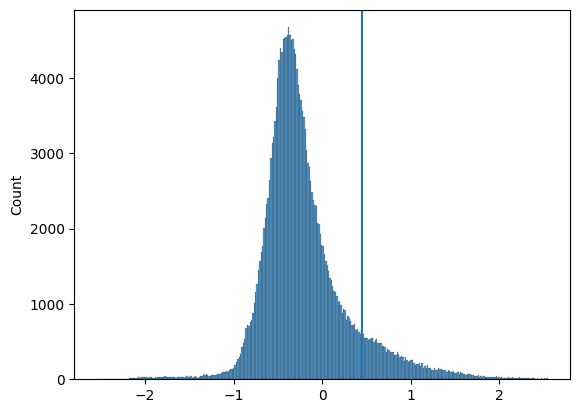

In [68]:
# sns.histplot(sz_prob.iloc[:,:3])
x = sz_prob.loc[:,:].values.ravel()
x_l = np.log(x[x < np.percentile(x,99.9)])
sns.histplot(x_l)
plt.axvline(np.log(1.57))

In [69]:
# mdl.get_cval_threshold()
# mdl.get_gaussianx_threshold(sz_prob)
mdl.get_knee_threshold(sz_prob=sz_prob)

1.5991039355821155

In [ ]:
_,sz_clf = mdl.get_onset_and_spread(sz_prob,
                                    rwin_size=15,
                                    rwin_req=14,
                                    ret_smooth_mat=True,
                                    )

In [85]:
dynasd_mask_wins = sz_clf.sum(axis=1) > 8

In [86]:
window_start_times = mdl.get_win_times(signal_ds_df.count().median().astype(int))
# Convert window start times to sample indices
start_sample_indices = (window_start_times * fs).astype(int)
end_sample_indices = ((window_start_times + 1) * fs).astype(int)

# Implement forward filling in window space
dynasd_mask_wins_ff = dynasd_mask_wins.copy()

# Ensure a classification is valid if at least `rwin_req_idx` out of `rwin_size_idx` future windows are true
for j in range(len(dynasd_mask_wins) - mdl.rwin_size_idx):
    if dynasd_mask_wins[j]:  # If window j is classified as true
        future_sum = np.sum(dynasd_mask_wins[j:j + mdl.rwin_size_idx])  # Count future true windows
        if future_sum >= mdl.rwin_req_idx:  # If requirement met, propagate forward
            dynasd_mask_wins_ff[j:j + mdl.rwin_size_idx] = True


# Initialize a sample-level seizure array (assume total duration is max end time)
sample_length = end_sample_indices[-1]  # Assuming last window extends to end
dynasd_mask = np.zeros(sample_length, dtype=bool)

# Map window classification to sample space
for start, end, is_seizing in zip(start_sample_indices, end_sample_indices, dynasd_mask_wins_ff):
    if is_seizing:  # Only mark if the window was classified as seizing
        dynasd_mask[start:end] = True


In [87]:
mask_true = annot.getMask(fs)

In [88]:
from timescoring.annotations import Annotation
from timescoring import scoring

In [89]:
hyp = Annotation(dynasd_mask,fs)
ref = Annotation(mask_true,fs)
param = scoring.EventScoring.Parameters(
    toleranceStart=30,
    toleranceEnd=60,
    minOverlap=0,
    maxEventDuration=5 * 60,
    minDurationBetweenEvents=90)
scores = scoring.EventScoring(ref, hyp, param)

# Event scoring
- Sensitivity : 0.00 
- Precision   : 0.00 
- F1-score    : 0.00 
- FP/24h      : 43.04 



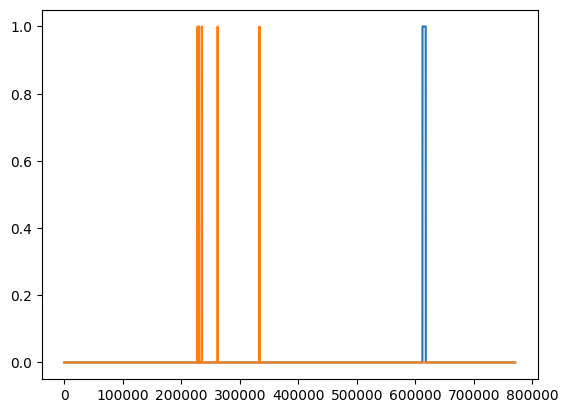

In [90]:
print("# Event scoring\n" +
      "- Sensitivity : {:.2f} \n".format(scores.sensitivity) +
      "- Precision   : {:.2f} \n".format(scores.precision) +
      "- F1-score    : {:.2f} \n".format(scores.f1) +
      "- FP/24h      : {:.2f} \n".format(scores.fpRate))
plt.plot(mask_true)
plt.plot(dynasd_mask)

In [807]:
results = pd.read_pickle('cval_results_df.pkl')
results['smoothing'] = results['smoothing'].astype(str)
# results = results[results.patient != 'sub-04']

In [808]:
results.head()


,patient,run,threshold,low_pass,high_pass,training,smoothing,spatial_threshold,sensitivity,precision,F1,fprate
0,sub-01,run-06,cval,1,55,10,"(4, 5)",4,1.0,0.5,0.666667,37.16129
1,sub-01,run-06,cval,1,55,10,"(4, 5)",6,1.0,1.0,1.000000,0.00000
2,sub-01,run-06,cval,1,55,10,"(4, 5)",9,1.0,1.0,1.000000,0.00000
3,sub-01,run-06,cval,1,55,10,"(9, 10)",4,1.0,1.0,1.000000,0.00000
4,sub-01,run-06,cval,1,55,10,"(9, 10)",6,1.0,1.0,1.000000,0.00000


In [809]:
results_mean = results.groupby(['threshold','low_pass','high_pass','training','smoothing','spatial_threshold'])[['sensitivity','precision','F1','fprate']].mean()
# results_mean['smoothing'] = results_mean['smoothing'].astype(str)

In [810]:
results_mean['F1'].idxmax()

('cval', 1, 100, 60, '(14, 15)', 9)

In [811]:
results_mean.loc[('cval', 1, 100, 60, '(14, 15)', 9)]

sensitivity     0.958333
precision       0.781382
F1              0.822720
fprate         20.687919
Name: (cval, 1, 100, 60, (14, 15), 9), dtype: float64

<Axes: xlabel='training', ylabel='F1'>

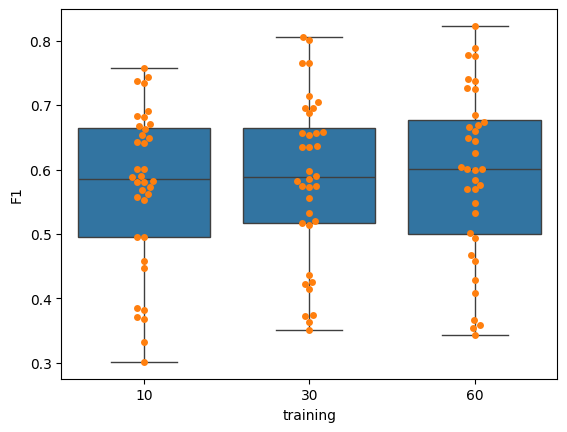

In [812]:
x = 'training'
y = 'F1'
sns.boxplot(results_mean,x=x,y=y)
sns.swarmplot(results_mean,x=x,y=y)

<Axes: xlabel='spatial_threshold', ylabel='smoothing'>

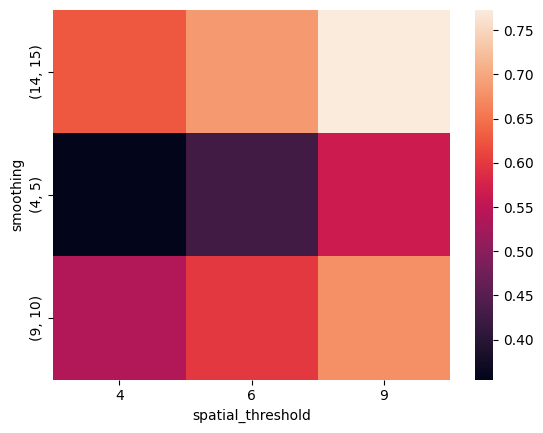

In [813]:
results_heat = results.groupby(['smoothing','spatial_threshold'])[['sensitivity','precision','F1','fprate']].mean()

glue = results_heat.reset_index().pivot(index="smoothing", columns="spatial_threshold", values="F1")
sns.heatmap(glue)